# Supervised Learning Models

**Group 19**

*Cátia Antunes* (fc60494) - 5h  
*Donato Aveiro* (fc46269) -  
*Márcia Vital* (fc59488) -   
*Seán Gorman* (fc59492) - 4/5h 

The goal of this first home assignment was to predict the critical temperature of a superconductor based on 81 extracted features.

In [184]:
# Importation of all modules required for the assignment
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [185]:
# Data loading 
df1 = pd.read_csv("train.csv")

In [186]:
#One hot encoding for categorical variables
df1 = pd.get_dummies(df1, columns=['number_of_elements'])

In [187]:
# Remove critical_temp and material from the dataframe
df2 = pd.read_csv("unique_m.csv")
df2.drop("critical_temp", axis=1, inplace=True)
df2.drop("material", axis=1, inplace=True)

In [188]:
# Merge the two data frames on the row index
df1 = pd.merge(df1, df2, left_index=True, right_index=True)

We began our data preprocess by taking a look at the data types of each column in order to see if there were some miss-labeled data types and if there were missing values. Since there were no missing values detected, it was not necessary to do any missing value imputation. (Outputs not show in order to save space.)

In [189]:
# As there were two data types, int and float, all integers where converted to float in order to have only one data type
df1[['range_atomic_radius', 'range_Valence']] = df1[[ 'range_atomic_radius', 'range_Valence']].astype(float)

# Temperature separation into classes
def critical_temp_sep(x):
    if x < 1.0:
        return 'VeryLow'
    elif x >= 1.0 and x < 5.0:
        return 'Low'
    elif x >= 5.0 and x < 20.0:
        return 'Medium'
    elif x >= 20.0 and x < 100.0:
        return 'High'
    else:
        return 'VeryHigh'

# Apply the function to the critical_temp column
df1['critical_temp classes'] = df1['critical_temp'].apply(critical_temp_sep)

# With the critical_temp classes created, we can remove our classification and regression labels from our X dataset and store them in two separate datasets, y_clf and y_reg, for the classification and regression tasks, respectively. 
y_clf = df1['critical_temp classes']
y_reg = df1['critical_temp']
X = df1.drop(columns=['critical_temp', 'critical_temp classes'])


With the removal of the classification and regression labels, we can now split our data into train and test datasets. For the classification data, in order to account for unbalanced classes, the performed split was done with stratification to guarantee an even class distribution in both train and test sets. This is not a necessary step for the split of the regression data. For both cases, the data was split with a XXX ratio (10% for testing).

In [190]:
# Data split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, 
                     test_size=0.1,
                     stratify=y_clf,
                     random_state=1)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, 
                    test_size=0.1,
                    random_state=1)

print('Train: ', X_train_clf.shape)
print('Test: ', X_test_clf.shape)

Train:  (19136, 175)
Test:  (2127, 175)


With the datasets divided into training and testing, we next proceeded to scale the datasets. This step needs to be done after the train and test split to avoid that the data present on the test dataset influences the training data. This problem is solved by first splitting the training and test sets and then fitting the scaler with the training set. The test set will be transformed with the fit done with the training set.
The scaling itself is an important process since there are features in different scales that would influence the algorithms. The standardization consists of bringing the features into a mean of zero and a standard variation of one.

In [191]:
# Scaling of training data for classification
std_scaler = StandardScaler()
X_train_clf = std_scaler.fit_transform(X_train_clf)
X_train_clf = pd.DataFrame(X_train_clf, columns = X.columns)

# Scaling of test data for classification
X_test_clf = std_scaler.transform(X_test_clf)
X_test_clf = pd.DataFrame(X_test_clf, columns = X.columns)

# Scaling of training data for linear regression
std_scaler = StandardScaler()
X_train_reg = std_scaler.fit_transform(X_train_reg)
X_train_reg = pd.DataFrame(X_train_reg, columns = X.columns)

# Transformation of testing data 
X_test_reg = std_scaler.transform(X_test_reg)
X_test_reg = pd.DataFrame(X_test_reg, columns = X.columns)


**PRINCIPAL COMPONENT ANALYSIS (PCA)**

In [192]:
# PCA for classification
pca = PCA(n_components = 0.9)
X_train_clf_pca = pca.fit_transform(X_train_clf)
X_test_clf_pca = pca.transform(X_test_clf)

# PCA for regression
pca = PCA(n_components = 0.9)
X_train_reg_pca = pd.DataFrame(pca.fit_transform(X_train_reg))
X_test_reg_pca = pd.DataFrame(pca.transform(X_test_reg))


### ***Modelling***

Regression Models

In [193]:
''' Linear regression of the PCA projection '''

# associate data with the variables here
X = X_train_reg_pca 
y = y_train_reg 

# Create and fit a linear regression model
model = linear_model.LinearRegression() # Create linear regression object
model.fit(X, y) # Train the model using the training sets

# Make predictions using the testing set
Superconduct_y_pred2 = model.predict(X_test_reg_pca)

# Evaluate the model performance
print("Mean squared error:", mean_squared_error(y_test_reg, Superconduct_y_pred2)) # print the MSE on training data
print("R2 score training data:", r2_score(y, model.predict(X))) # print the R2 score on training data
print("R2 score test data:", r2_score(y_test_reg, Superconduct_y_pred2)) # the R2 score on test data


Mean squared error: 376.34320368983714
R2 score training data: 0.6650364798934614
R2 score test data: 0.6738888100756271


In [194]:
''' Linear regression of the full dataset '''

# associate data with the variables here
X = X_train_reg ##### Replace here with full clean data
y = y_train_reg ##### Replace here with full clean data

# Create and fit a linear regression model
model = linear_model.LinearRegression() # Create linear regression object
model.fit(X, y) # Train the model using the training sets 

# Make predictions using the testing set
Superconduct_y_pred = model.predict(X_test_reg) ##### Replace here with test  

# Evaluate the model performance
print("Mean squared error training data:", mean_squared_error(y, model.predict(X))) # print the MSE on training data
print("Mean squared error test data:", mean_squared_error(y_test_reg, Superconduct_y_pred)) # print the MSE on test data
print("R2 score training data:", r2_score(y, model.predict(X))) # print the R2 score on training data
print("R2 score test data:", r2_score(y_test_reg, Superconduct_y_pred)) # the R2 score on test data



Mean squared error training data: 273.62992083089097
Mean squared error test data: 277.6586435857355
R2 score training data: 0.7672117948800702
R2 score test data: 0.7594015521875711


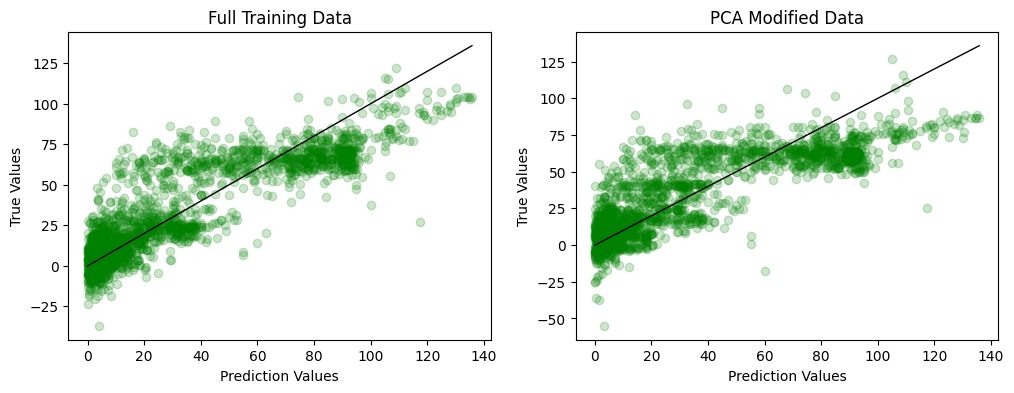

In [195]:
''' Linear Regression Plots '''
def CreateRegPlots(y_test_reg, y_predict, X_test, title=""):
    plt.scatter(y_test_reg, y_predict, color='green', alpha=0.2)
    plt.xlabel("Prediction Values")
    plt.ylabel("True Values")
    plt.title(title)
    plt.plot([min(y_test_reg),max(y_test_reg)], [min(y_test_reg),max(y_test_reg)], linestyle="-", lw=1, color="k")

figure = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
CreateRegPlots(y_test_reg, Superconduct_y_pred, X_test_reg, "Full Training Data")
plt.subplot(1, 2, 2)
CreateRegPlots(y_test_reg, Superconduct_y_pred2, X_test_reg, "PCA Modified Data")
plt.show()

In [196]:
''' Decision Tree Regressor '''

results = {'Model':[], 'MSE (training)':[], 'MSE (test)':[], 'R2 (training)':[], 'R2 (test)':[]}

# Train and evaluate the model on the original data
model = DecisionTreeRegressor()
model.fit(X_train_reg, y_train_reg)
y_train_pred = model.predict(X_train_reg)
y_test_pred = model.predict(X_test_reg)

results['Model'].append('Decision Tree Regressor')
results['MSE (training)'].append(mean_squared_error(y_train_reg, y_train_pred))
results['MSE (test)'].append(mean_squared_error(y_test_reg, y_test_pred))
results['R2 (training)'].append(r2_score(y_train_reg, y_train_pred))
results['R2 (test)'].append(r2_score(y_test_reg, y_test_pred))

# Train and evaluate the model on the PCA-transformed data
model = DecisionTreeRegressor()
model.fit(X_train_reg_pca, y_train_reg)
y_train_pred2 = model.predict(X_train_reg_pca)
y_test_pred2 = model.predict(X_test_reg_pca)

results['Model'].append('Decision Tree Regressor (PCA)')
results['MSE (training)'].append(mean_squared_error(y_train_reg, y_train_pred2))
results['MSE (test)'].append(mean_squared_error(y_test_reg, y_test_pred2))
results['R2 (training)'].append(r2_score(y_train_reg, y_train_pred2))
results['R2 (test)'].append(r2_score(y_test_reg, y_test_pred2))

# Convert the dictionary to a pandas DataFrame
df_results = pd.DataFrame(results)

# Print the results
df_results

,Model,MSE (training),MSE (test),R2 (training),R2 (test)
0,Decision Tree Regressor,16.910327,176.392414,0.985614,0.847151
1,Decision Tree Regressor (PCA),16.910327,177.742542,0.985614,0.845981


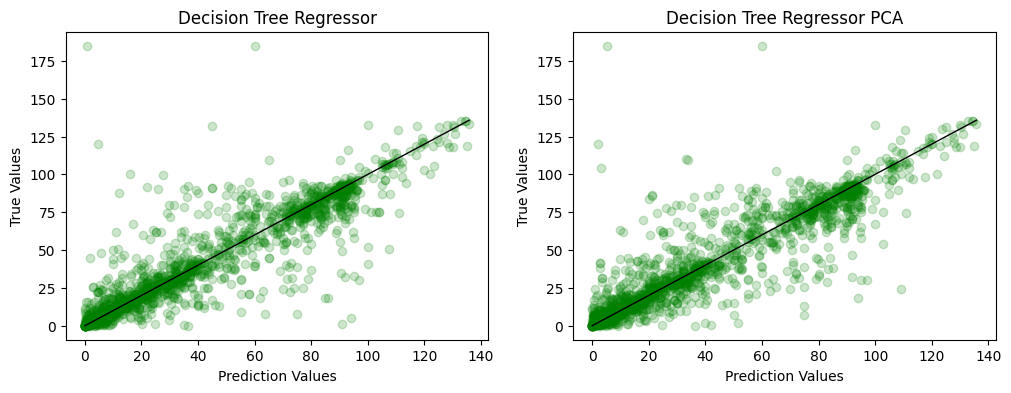

In [197]:
figure = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
CreateRegPlots(y_test_reg, y_test_pred, X_test_reg, "Decision Tree Regressor")
plt.subplot(1, 2, 2)
CreateRegPlots(y_test_reg, y_test_pred2, X_test_reg, "Decision Tree Regressor PCA")
plt.show()

Linear Model (LRM) vs Decision Tree Model (DTM) - Discussion

The results of the LRM model show a MSE of 273.63 on the training data and 277.71 on the test data, demonstrating that the test data's average squared discrepancy between the model's predicted and actual values is higher. The R2 score for the linear regression model is 0.77 on the training data and 0.76 on the test data, indicating that the model explains about 77% of the variance in the target variable on the training data and 76% on the test data.
The DTM performs better than the LRM on the training data, with a MSE of 16.91 and an R2 score of 0.99. However, on the test data, the MSE of the DTM is 188.70, which is higher than that of the LRM, indicating that the DTM is not performing as well on unseen data. The R2 score of the decision tree model on the test data is 0.84, which is higher than that of the LRM, indicating that the DTM explains about 84% of the variance in the target variable on the test data.
Overall, the DTM outperforms the LRM in terms of R2 score on both the training and test data. However, the performance of the decision tree model on the test data indicates that it may be overfitting to the training data, highlighting the importance of evaluating the model's generalization ability on unseen data.

In [145]:
#hyperparameter tuning
param_grid = {
    'criterion': ['squared_error', 'poisson'],
    'max_depth': [5, 10, 15, 20, 25, 35, 50],
    'min_samples_split': [1, 2, 5, 20, 30],
    'min_samples_leaf': [1, 2, 5, 10]}

mod = DecisionTreeRegressor()
grid_search = GridSearchCV(estimator = mod, param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 0)

grid_search.fit(X_train_reg, y_train_reg)

grid_search.best_params_

#predict the values
y_pred_dt = grid_search.predict(X_test_reg)


Decision Tree model accuracy(in %): 88.56217745621358
Mean squared error: 131.99629182803181


In [147]:
#MSE on the training data and test data
print("Decision Tree model accuracy(in %):", r2_score(y_test_reg, y_pred_dt)*100)
print("Mean squared error training data:", mean_squared_error(y_train_reg, grid_search.predict(X_train_reg)))
print("Mean squared error test data:", mean_squared_error(y_test_reg, y_pred_dt))

Decision Tree model accuracy(in %): 88.56217745621358
Mean squared error training data: 63.2494783429371
Mean squared error test data: 131.99629182803181


CLASSIFICATION MODELS

In [198]:
vals, counts= np.unique(y_clf, return_counts=True)
print("0 - VeryLow, 1 - Low, 2 - Medium, 3 - High, 4 - VeryHigh")
for v, c in zip(vals, counts):
    print("# of ",v, "--->", c)

0 - VeryLow, 1 - Low, 2 - Medium, 3 - High, 4 - VeryHigh
# of  High ---> 9874
# of  Low ---> 4018
# of  Medium ---> 5568
# of  VeryHigh ---> 802
# of  VeryLow ---> 1001


In [199]:
# calculate the proportion of each class in the dataset
total_samples = 20563
class_very_low = 1036 / total_samples
class_low = 4057 / total_samples
class_medium = 5623 / total_samples
class_high = 9779 / total_samples
class_very_high = 768 / total_samples

# set the prior probabilities for each class
prior_sum = class_very_low + class_low + class_medium + class_high + class_very_high
class_prior = [class_very_low/prior_sum, class_low/prior_sum, class_medium/prior_sum, 
               class_high/prior_sum, class_very_high/prior_sum]

In [200]:
results = {'Model':[], 'Accuracy (training)':[], 'Accuracy (test)':[], 'Precision':[], 'Recall':[], 'F1 Score ':[]}

# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "Naive Bayes with Prior": GaussianNB(priors=class_prior)}

# Train and test models on all the data and PCA modified data
for data_type, X_train, X_test, y_train, y_test in [("All Data", X_train_clf, X_test_clf, y_train_clf, y_test_clf), 
                                                    ("PCA Data", X_train_clf_pca, X_test_clf_pca, y_train_clf, y_test_clf)]:
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc_train = model.score(X_train, y_train)
        acc_test = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

        results['Model'].append(model_name + " with " + data_type)
        results['Accuracy (training)'].append(acc_train)
        results['Accuracy (test)'].append(acc_test)
        results['Precision'].append(precision)
        results['Recall'].append(recall)
        results['F1 Score '].append(f1)

pd.DataFrame(results)

,Model,Accuracy (training),Accuracy (test),Precision,Recall,F1 Score
0,Decision Tree with All Data,0.974133,0.818524,0.817011,0.818524,0.817490
1,Naive Bayes with All Data,0.352843,0.373296,0.612668,0.373296,0.405132
2,Naive Bayes with Prior with All Data,0.353000,0.372826,0.612464,0.372826,0.404709
3,Decision Tree with PCA Data,0.974133,0.820404,0.820571,0.820404,0.819973
4,Naive Bayes with PCA Data,0.506271,0.497414,0.462303,0.497414,0.458707
5,Naive Bayes with Prior with PCA Data,0.497962,0.489422,0.464502,0.489422,0.458636


The decisicon tree clearly gives better results (f1 score of 0.82) compared to the naive bayes classifier, even with the priors pre-calculated (both with an f1 score of 0.4). However, it's important to note that the decision tree scores significantly less on the testing data relative to the training data when compared with the naive bayes classifiers. We'll try some hyperparameter tuning to reduce the overfitting of the deciscion tree and increase overall performance. 

In [160]:
#hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, 25, 35, 50],
    'min_samples_split': [1, 2, 5, 20, 30],
    'min_samples_leaf': [1, 2, 5, 10]
}

grid_search = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 0)

grid_search.fit(X_train_clf, y_train_clf)

#predict the values
y_pred_dt = grid_search.predict(X_test_clf)

Decision Tree Accuracy:  0.8293370944992948


In [201]:
#f1 score of the model on training vs test data
print("F1 score training data:", f1_score(y_train_clf, grid_search.predict(X_train_clf), average='weighted'))
print("F1 score test data:", f1_score(y_test_clf, y_pred_dt, average='weighted'))


F1 score training data: 0.9740326128704627
F1 score test data: 0.8287356382176471


<Axes: >

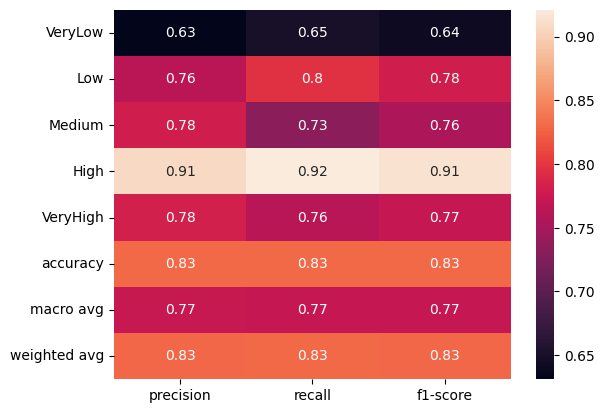

In [202]:
#plot the classification report
labels = ['VeryLow', 'Low', 'Medium', 'High', 'VeryHigh']
report = pd.DataFrame(classification_report(y_test_clf, y_pred_dt, output_dict=True, labels=labels)).transpose()
hm = sns.heatmap(report.iloc[:, :-1], annot=True)
hm

Although the decision tree proved to be the best model, tuning the hyperparameters ultimately did little to prevent overfitting to the training data. The final results can be seen above. The heatmap represents the classification report of the tuned decision tree. Unsurprisingly, the model classifies the "High" critical temp class the best. This is undoubtedly due to there being a significantly higher number of instances of this class (9874). Obtaining a dataset with a more regular distribution of instances would go a long way to improving model robustness and accuracy. 